In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import glob
from pprint import pprint

Number of boxes: 75


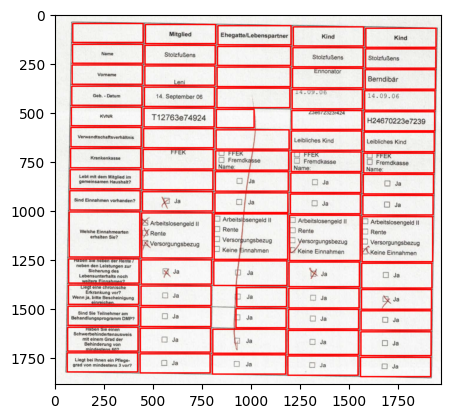

In [224]:
#export
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import glob
from pprint import pprint



RHO = 1  # distance resolution in pixels of the Hough grid
THETA = np.pi / 180  # angular resolution in radians of the Hough grid
THRESHOLD = 15  # minimum number of votes (intersections in Hough grid cell)
HORIZONTAL_MIN_LINE_LENGTH = 50  # (recommend at 50)
VERTICAL_MIN_LINE_LENGTH = 600  # (recommend at 700)
MAX_LINE_GAP = 50  # maximum gap in pixels between connectable line segments (original = 20)

PERCENT_BOX_MAX_WIDTH = 0.4
PERCENT_BOX_MIN_WIDTH = 0.1
PERCENT_BOX_MAX_HEIGHT = 0.5
PERCENT_BOX_MIN_HEIGHT = 0.03


def detect_box(image):
    mask = np.zeros(image.shape, dtype=np.uint8)
    mask_2 = mask.copy()
    gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray_scale, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Detect the grid
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area > 100000:
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)
            cv2.drawContours(mask_2, [c], -1, (255,255,255), 10)
            
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask_2 = cv2.cvtColor(mask_2, cv2.COLOR_BGR2GRAY)
    filled_mask = mask_2.copy()
    mask = cv2.bitwise_and(mask, thresh)

    # Find horizontal line
    kernal_h = cv2.getStructuringElement(cv2.MORPH_RECT, (55,1))
    detect_horizontal = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernal_h, iterations=1)
    detect_horizontal = cv2.dilate(detect_horizontal, kernal_h, iterations = 5)
    lines = cv2.HoughLinesP(detect_horizontal, RHO, THETA, THRESHOLD, np.array([]),
                        HORIZONTAL_MIN_LINE_LENGTH, MAX_LINE_GAP)

    for line in lines:
        for x1,y1,x2,y2 in line:
              cv2.line(filled_mask,(x1,y1),(x2,y2),(128,128,128),3)
#     ###
#     print(f'Horizontal masked')
#     plt.imshow(filled_mask)
#     plt.show()
#     ###
    # Find vertical lines
    kernal_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1,55))
    detect_vertical = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernal_v, iterations=2)
    detect_vertical = cv2.dilate(detect_vertical, kernal_v, iterations = 10)
    lines = cv2.HoughLinesP(detect_vertical, RHO, THETA, THRESHOLD, np.array([]),
                        VERTICAL_MIN_LINE_LENGTH, MAX_LINE_GAP)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(filled_mask,(x1,y1),(x2,y2),(128,128,128),3)
#     ###
#     print(f'Vertical masked')
#     plt.imshow(filled_mask)
#     plt.show()
#     ###    
    img_bin_final = cv2.bitwise_and(mask, filled_mask)
    img_bin_final = cv2.threshold(img_bin_final, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    final_kernel = np.ones((3,3), np.uint8)
    img_bin_final = cv2.dilate(~img_bin_final, final_kernel, iterations=5)
    
    ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    for x,y,w,h,area in stats:
            image_temp = image.copy()
            cv2.rectangle(image_temp,(x,y),(x+w,y+h),(255,0,0), 5)

    # Sorted row
    stats = stats[2:]
    stats = sorted(stats.tolist(), key=lambda b:b[1], reverse=False)
    
    # Sort column
    # Creating a list of heights for all detected boxes
    heights = [stats[i][3] for i in range(len(stats))]
    
    # Get mean
    mean = np.mean(heights)

    #Creating two lists to define row and column in which cell is located
    row=[]
    column=[]
    #Sorting the boxes to their respective row and column
    box = stats
    for i in range(len(box)):
        if(i==0):
            column.append(box[i])
            previous=box[i]
        else:
            if(box[i][1]<=previous[1]+mean/2):
                column.append(box[i])
                previous=box[i]
                if(i==len(box)-1):
                    column.sort(key= lambda row: (row[0]))
                    row.append(column)
            else:
                column.sort(key= lambda row: (row[0]))
                row.append(column)
                column=[]
                previous = box[i]
                column.append(box[i])

    return row, labels


def every_box(image):
    stats,labels=detect_box(image)
    row = 1
    count_image = 0
    for stat in stats:
        total_column = len(stat[0])
        column = 1
        for x, y, w, h,area in stat:
            if image.shape[0]*PERCENT_BOX_MAX_WIDTH > w > image.shape[0]*PERCENT_BOX_MIN_WIDTH \
            and image.shape[1]*PERCENT_BOX_MAX_HEIGHT > h > image.shape[1]*PERCENT_BOX_MIN_HEIGHT:
                image_temp = image.copy()
                # Check one by one
                print(f'Row: {row}, Column: {column}')
                cv2.rectangle(image_temp,(x,y),(x+w,y+h),(255,0,0), 5)
                plt.imshow(image_temp)
                plt.show()
                column += 1
                count_image += 1
        row += 1
    
    print(f'Number of images: {count_image}')
    print(row-2,total_column)
    if count_image == (row-2)*(total_column):
        return True


def one_pic(image):
    stats, labels = detect_box(image)
    count_image = 0
    for stat in stats:
        for x, y, w, h, area in stat:
            if image.shape[0]*PERCENT_BOX_MAX_WIDTH > w > image.shape[0]*PERCENT_BOX_MIN_WIDTH \
            and image.shape[1]*PERCENT_BOX_MAX_HEIGHT > h > image.shape[1]*PERCENT_BOX_MIN_HEIGHT:
                cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0), 5)
                count_image += 1
    print(f'Number of boxes: {count_image}')
    plt.imshow(image)
    
image_path = 'tables/36.png'
image = cv2.imread(image_path)
one_pic(image)
# detect_box(image)


In [237]:
folder_dir = 'tables'
image = cv2.imread(image_path)

def check_every_photo(folder_dir):
    incorrect = []
    png_file = 0
    for file in os.listdir('tables'):
        if(file.endswith('.png')):
            png_file += 1
            image_path = f'{folder_dir}/{file}'
            image = cv2.imread(image_path)
            stats, labels = detect_box(image)
            count_boxes = 0
            for stat in stats:
                for x, y, w, h,area in stat:
                    if image.shape[0]*PERCENT_BOX_MAX_WIDTH > w > image.shape[0]*PERCENT_BOX_MIN_WIDTH \
                    and image.shape[1]*PERCENT_BOX_MAX_HEIGHT > h > image.shape[1]*PERCENT_BOX_MIN_HEIGHT:
                        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0), 5)
                        count_boxes += 1
            print(f'File name: {file}')            
            print(f'Number of boxes: {count_boxes}')
            if count_boxes % 5 == 0:
                print('Correct')
            else:
                print('Incorrect')
                incorrect.append(file)
            print("\n=============\n")
    print(f"Incorrect photos: {incorrect}")
    mistake_percent = len(incorrect)*100/png_file
    print(f"Total Mistakes: {len(incorrect)}/{png_file}")
    print(f"Mistake percentage: {round(mistake_percent,2)}%")

check_every_photo(folder_dir)

File name: 8.png
Number of boxes: 75
Correct


File name: 9.png
Number of boxes: 70
Correct


File name: 98.png
Number of boxes: 75
Correct


File name: 115.png
Number of boxes: 75
Correct


File name: 14.png
Number of boxes: 75
Correct


File name: 28.png
Number of boxes: 75
Correct


File name: 29.png
Number of boxes: 70
Correct


File name: 15.png
Number of boxes: 75
Correct


File name: 114.png
Number of boxes: 75
Correct


File name: 102.png
Number of boxes: 70
Correct


File name: 17.png
Number of boxes: 75
Correct


File name: 16.png
Number of boxes: 70
Correct


File name: 117.png
Number of boxes: 70
Correct


File name: 103.png
Number of boxes: 70
Correct


File name: 107.png
Number of boxes: 70
Correct


File name: 113.png
Number of boxes: 75
Correct


File name: 12.png
Number of boxes: 75
Correct


File name: 13.png
Number of boxes: 70
Correct


File name: 112.png
Number of boxes: 70
Correct


File name: 106.png
Number of boxes: 70
Correct


File name: 110.png
Number of boxe